# Getting started

In [1]:
from pymultieis.multieis import *

In [2]:
import numpy as np
import torch

In [3]:
# Load the file containing the frequencies
F = torch.as_tensor(np.load('../../../data/redox_exp_50/freq_50.npy'))
# Load the file containing the admittances (a set of 50 spectra)
Y = torch.as_tensor(np.load('../../../data/redox_exp_50/Y_50.npy'))
# Load the file containing the standard deviation of the admittances
Yerr = torch.as_tensor(np.load('../../../data/redox_exp_50/sigma_Y_50.npy'))


In [4]:
print(F.shape)
print(Y.shape)
print(Yerr.shape)

torch.Size([45])
torch.Size([45, 50])
torch.Size([45, 50])


In [5]:
def redox(p, f):
    w = 2*torch.pi*f               # Angular frequency
    s = 1j*w                       # Complex variable
    Rs = p[0]
    Qh = p[1]
    nh = p[2]
    Rct = p[3]
    Wct = p[4]
    Rw = p[5]
    Zw = Wct/torch.sqrt(w) * (1-1j) # Planar infinite length Warburg impedance
    Ydl = (s**nh)*Qh                # admittance of a CPE
    Z1 = (1/Zw + 1/Rw)**-1
    Z2 = (Rct+Z1)
    Y2 = Z2**-1
    Y3 = (Ydl + Y2)
    Z3 = 1/Y3
    Z = Rs + Z3
    Y = 1/Z
    return torch.cat((Y.real, Y.imag), dim = 0)


In [6]:
p0 = torch.as_tensor([1.6295e+02, 3.0678e-08, 9.3104e-01, 1.1865e+04, 4.7125e+05, 1.3296e+06])

bounds = [[1e-15,1e15], [1e-8, 1e2], [1e-1,1e0], [1e-15,1e15], [1e-15,1e15], [1e-15,1e15]]

smf_sigma = torch.as_tensor([100000., 100000., 100000., 100000., 100000., 100000.]) # Smoothing factor used with the standard deviation

smf_modulus = torch.as_tensor([1., 1., 1., 1., 1., 1.]) # Smoothing factor used with the modulus

labels = {"Rs":"$\Omega$", "Qh":"$F^{nh}$", "nh":"-", "Rct":"$\Omega$", "Wct":"$\Omega\cdot^{-0.5}$", "Rw":"$\Omega$"}



1. using the standard deviation as weighting

In [7]:
eis_redox_sigma = Multieis(p0, F, Y, bounds, smf_sigma, redox, weight= Yerr, immittance='admittance')

In [8]:
popt, perr, chisqr, chitot, AIC = eis_redox_sigma.fit_deterministic2()

Iteration : 1000, Loss : 2.62063e+01
Iteration : 1842, Loss : 2.55806e+01
Optimization complete
total time is 0:00:26.283156 

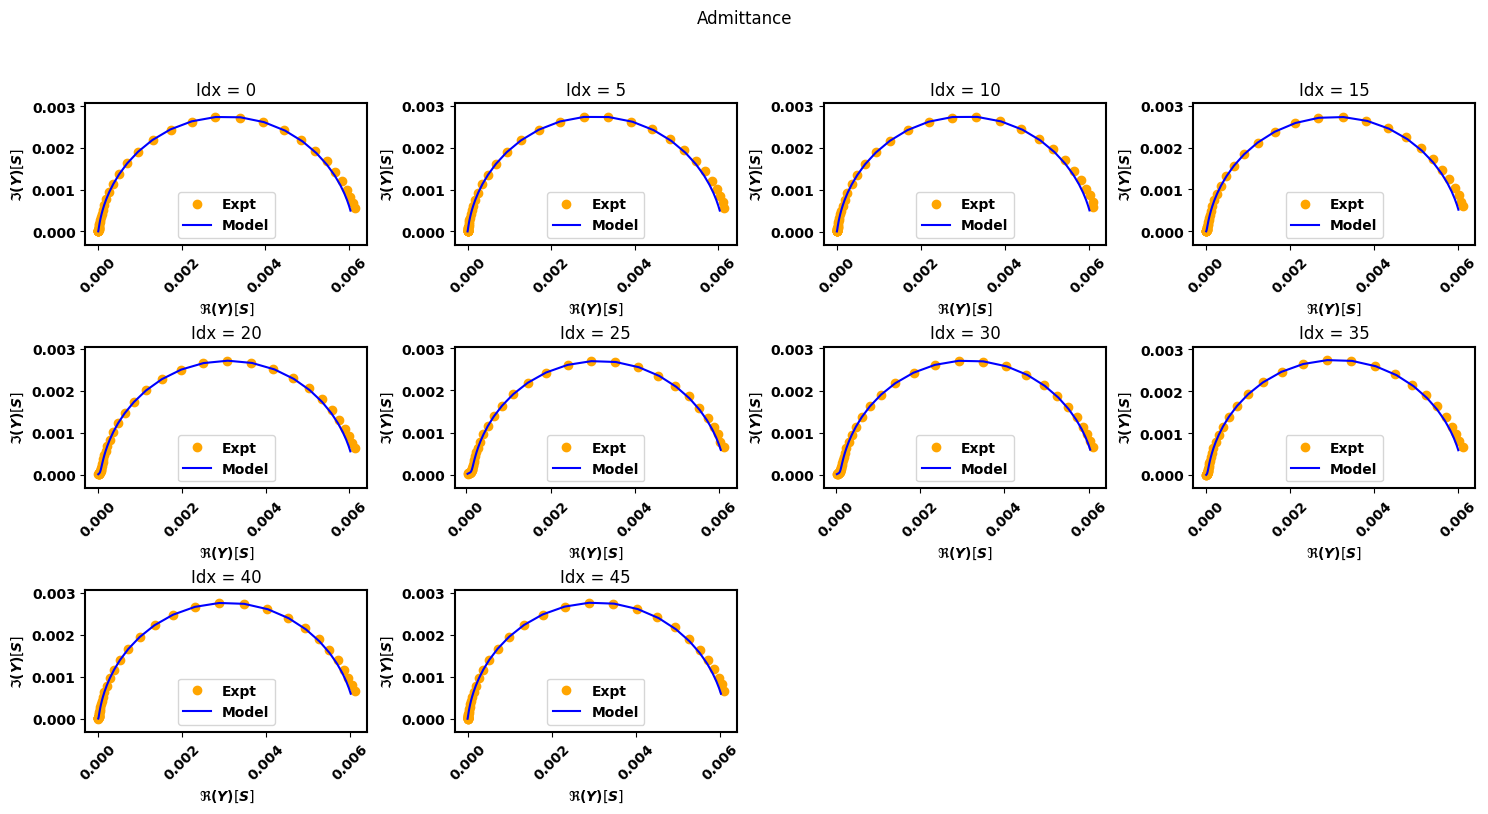

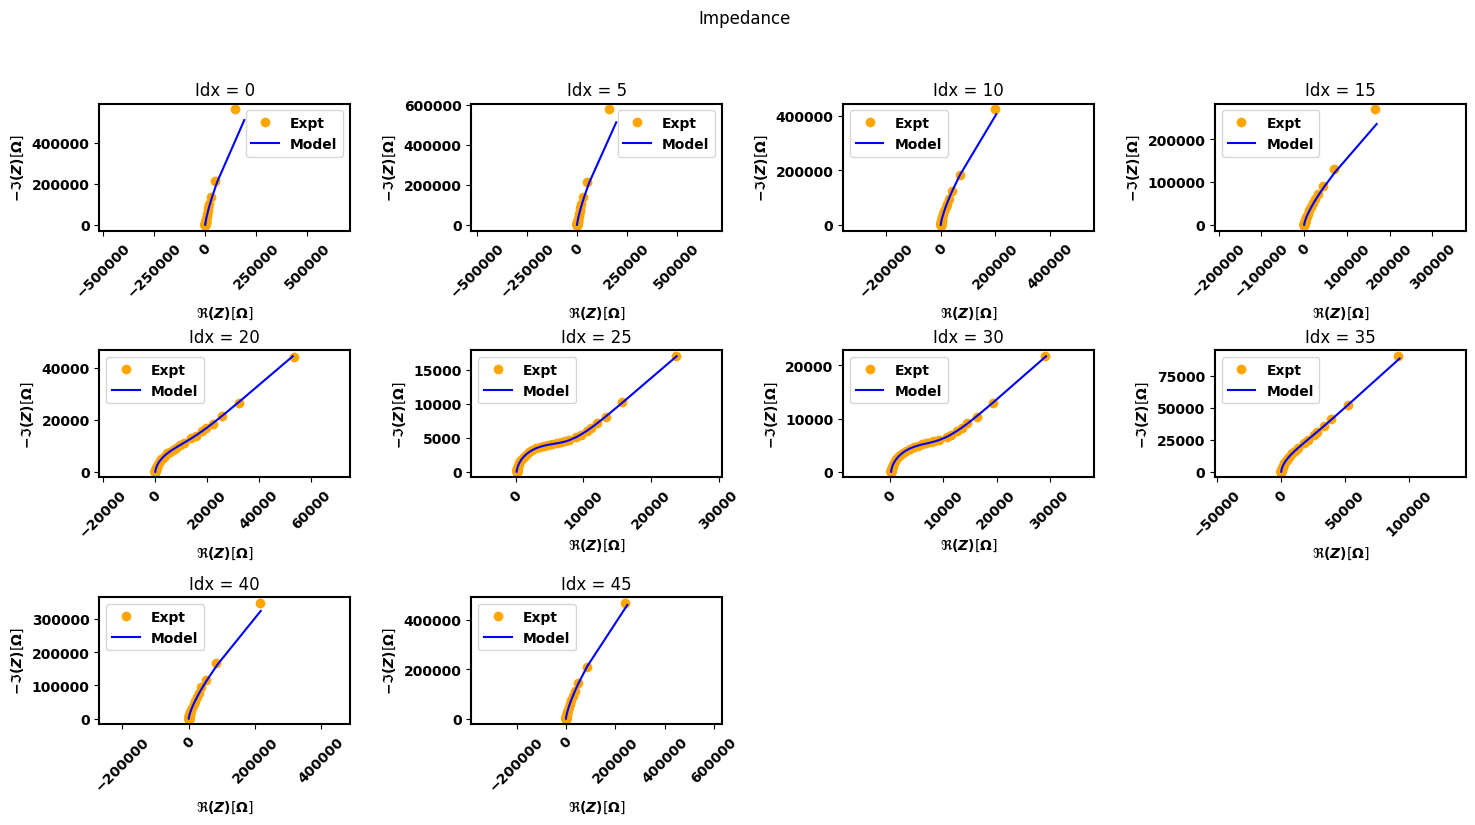

In [9]:
eis_redox_sigma.plot_nyquist(5)

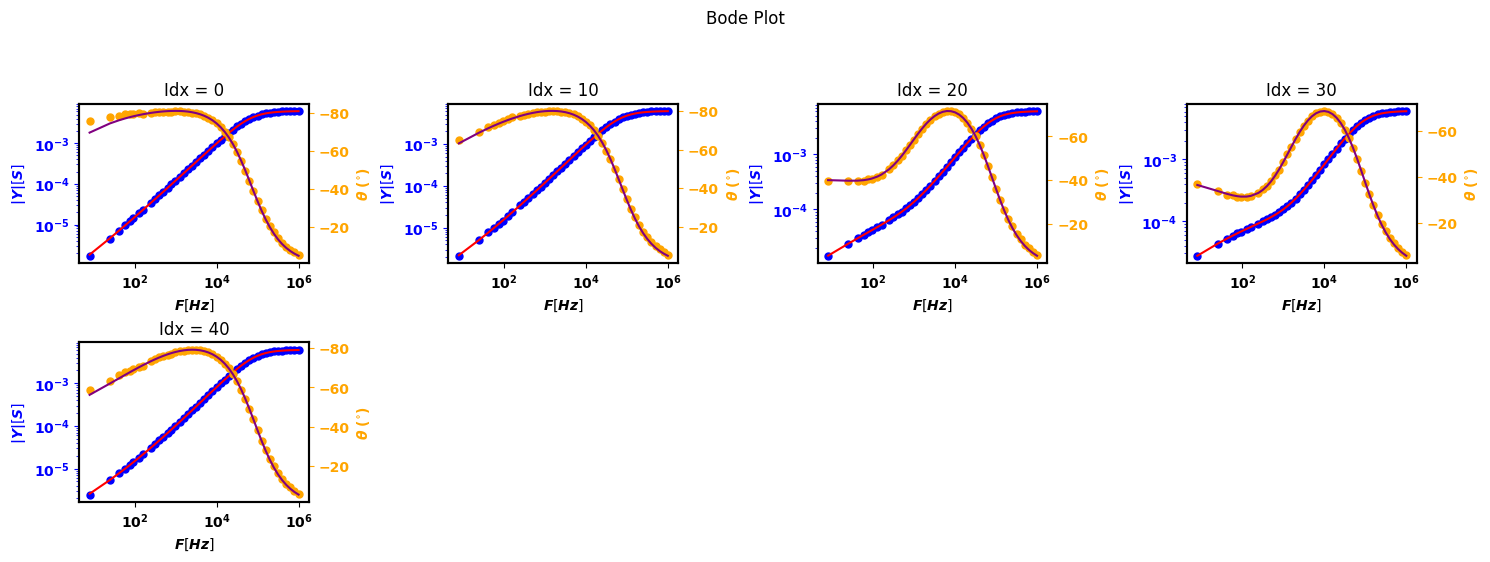

In [10]:
eis_redox_sigma.plot_bode(steps = 10)

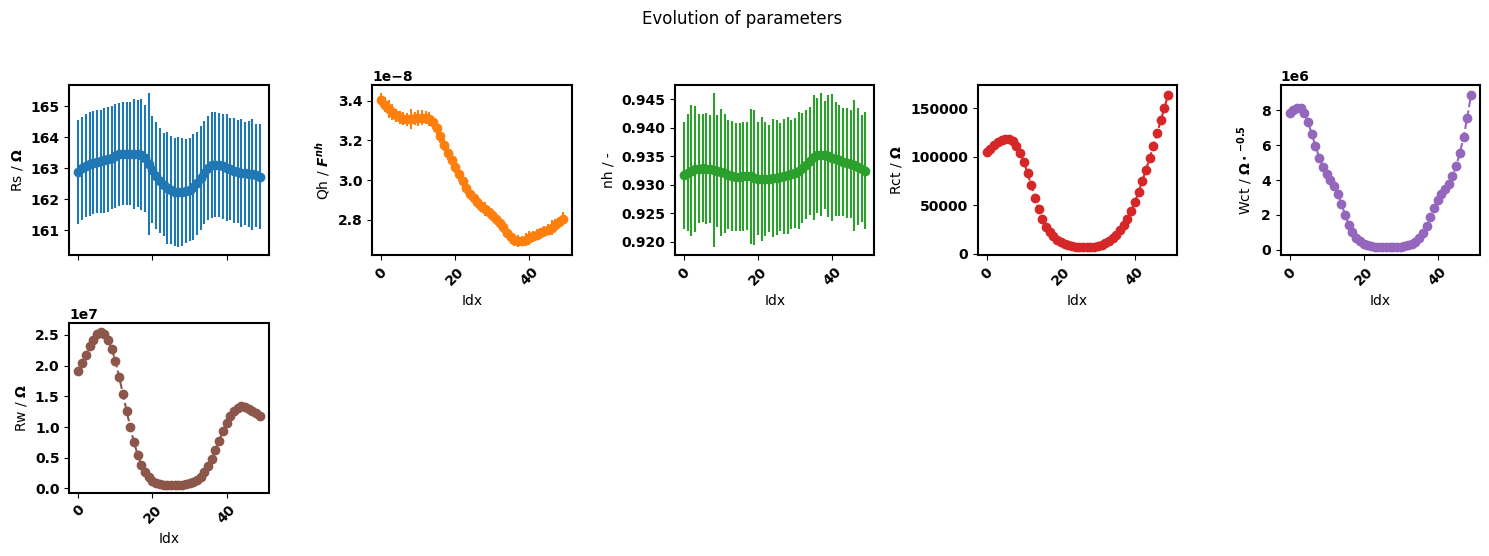

In [11]:
eis_redox_sigma.plot_params(True, labels=labels)

2. Using the modulus as weighting

There are many cases where we do not have the data for the standard deviation of the admittance or impedance. ``pymultieis`` offers other weighting options. 
In this second example we shall fit using the modulus as the weighting. All you need do is set the weight to the string "modulus".

In [12]:
eis_redox_modulus = Multieis(p0, F, Y, bounds, smf_modulus, redox, weight= 'modulus', immittance='admittance')

In [13]:
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_deterministic()

Using p0
Iteration : 1000, Loss : 4.53305e-05
Iteration : 2000, Loss : 3.89697e-05
Iteration : 2478, Loss : 3.80747e-05
Optimization complete
total time is 0:00:33.800548 

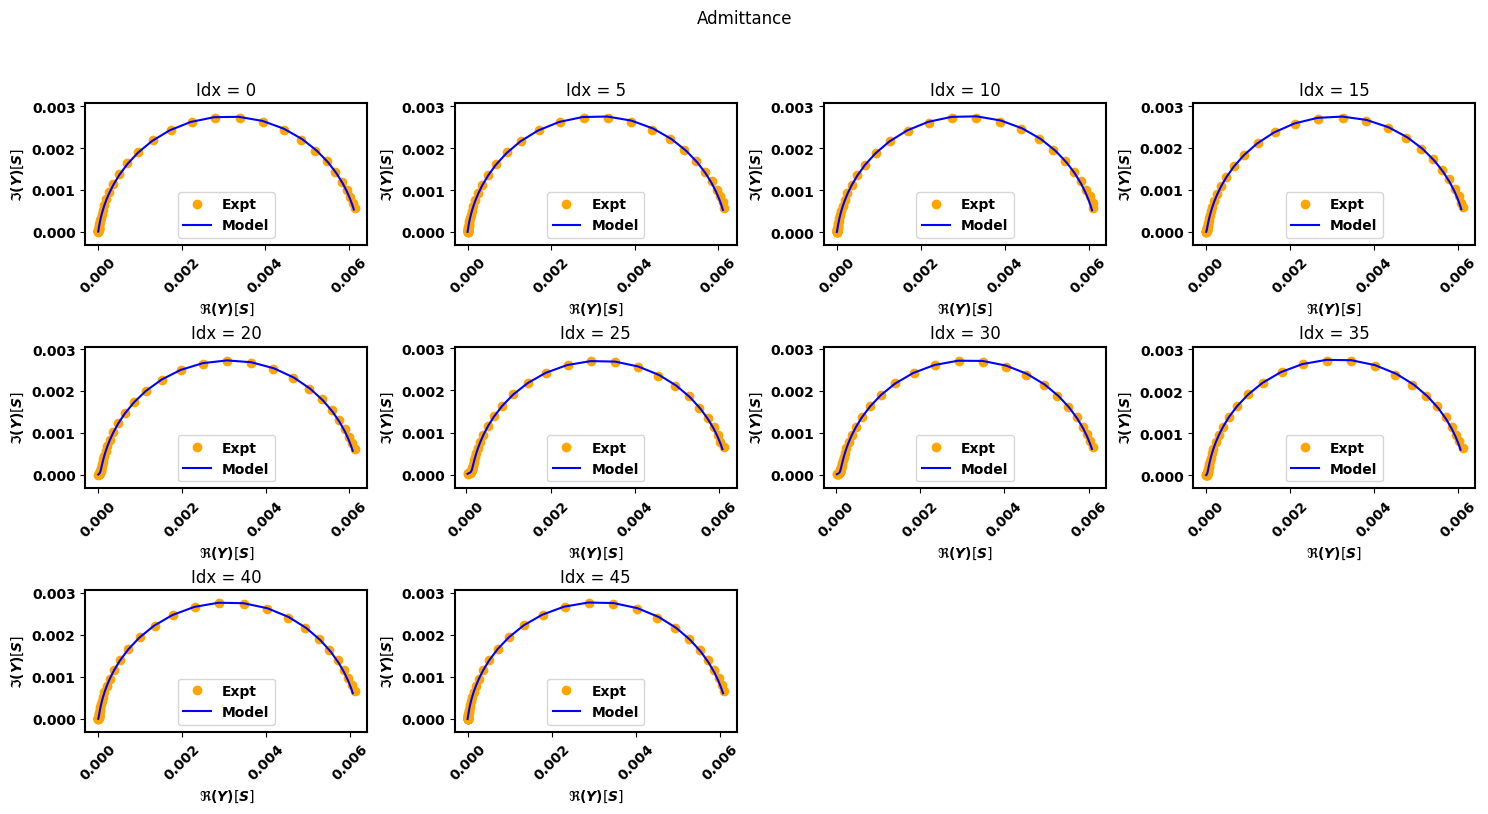

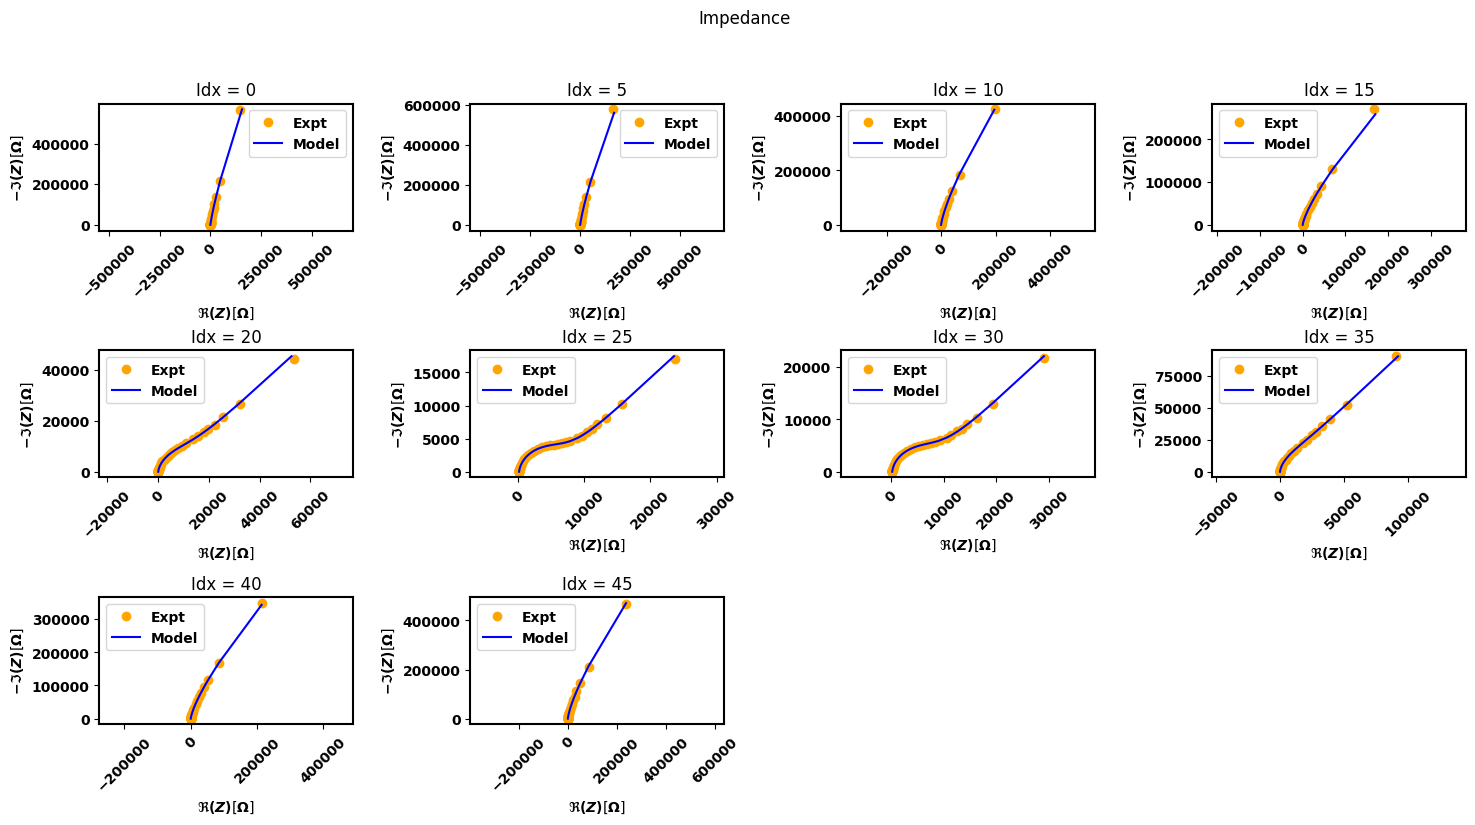

In [14]:
eis_redox_modulus.plot_nyquist(5)

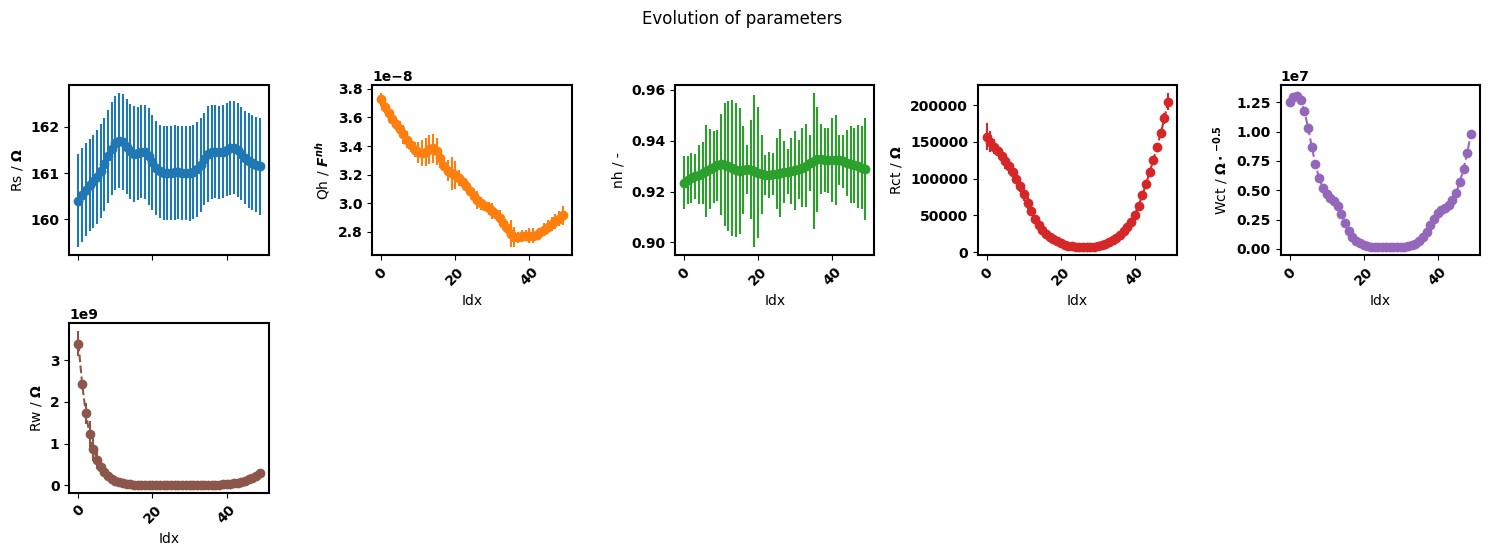

In [18]:
eis_redox_modulus.plot_params(labels=labels, show_errorbar = True)

3. Saving the plots

In [16]:
eis_redox_modulus.save_plot_nyquist(steps=10, fname='example_results')
# eis_redox_modulus.save_plot_bode(steps=10, fname='example_results')
# eis_redox_modulus.save_plot_params(False, fname='example_results')

4. saving the results

In [17]:
eis_redox_modulus.save_results(fname='example_results')